In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
train_data = pd.read_csv('dataset.csv')
#default label 0 = glaucoma 1 = normal 2 = others
train_data.loc[train_data.label == 0, 'label'] = 3
train_data.loc[train_data.label == 2, 'label'] = 0
train_data.loc[train_data.label == 1, 'label'] = 0
train_data.loc[train_data.label == 3, 'label'] = 1
train_data['label'] = train_data['label'].astype(str)
Y = train_data[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)


idg = ImageDataGenerator(rescale = 1./255,
                        shear_range = 0.2,
                        zoom_range = 0.2,
                        horizontal_flip = True)

In [3]:
def create_new_model():
    IMAGE_SIZE = [32, 32]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [4]:
def main():
    VALIDATION_ACCURACY = []
    VALIDATION_LOSS = []
    
    image_dir = 'dataset'
    save_dir = 'gsaved_models/'
    fold_var = 1
    num_epochs = 15
    
    for train_index, val_index in skf.split(np.zeros(4044),Y):

        training_data = train_data.iloc[train_index]
        validation_data = train_data.iloc[val_index]
        
        train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                                                       x_col = 'filename', y_col = 'label',
                                                       target_size = (32, 32),batch_size = 16,
                                                       class_mode = "binary", shuffle = True)
        valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)
        # CREATE NEW MODEL
        model = create_new_model()

        # COMPILE NEW MODEL
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        # CREATE CALLBACKS
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var),
                                                        monitor='val_accuracy', verbose=1,
                                                        save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model

        # FIT THE MODEL
        history = model.fit_generator(train_data_generator,
                            epochs=15,
                            callbacks=callbacks_list,
                            validation_data=valid_data_generator)
        
        # Extract valid_data_generator
        valid_data_generator.reset()
        
        X_test, y_test = next(valid_data_generator)
        
        batch_index = 0
        while batch_index <= valid_data_generator.batch_index:
            img, label = next(valid_data_generator)
            X_test = np.append(X_test, img, axis=0 )
            y_test = np.append(y_test, label, axis=0)
            batch_index = batch_index + 1
        
                
        # PLOT HISTORY        
        y_pred = model.predict(X_test).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
        
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='ROC fold {} (AUC = {:.2f})'.format(fold_var,auc_keras))

        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights("gsaved_models/model_" + str(fold_var) + ".h5")

        results = model.evaluate(valid_data_generator)
        results = dict(zip(model.metrics_names, results))
        
                
        VALIDATION_ACCURACY.append(results['accuracy'])
        VALIDATION_LOSS.append(results['loss'])
        
        tf.keras.backend.clear_session()
        
        fold_var += 1
        
    plt.xlabel('False Positive Rate (Positive label: 1)')
    plt.ylabel('True Positive Rate (Positive label: 1)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='best')
    plt.savefig('Graph/vgg16_glaucoma_graph.jpg')
    plt.show()  

Found 3235 validated image filenames belonging to 2 classes.
Found 809 validated image filenames belonging to 2 classes.


c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 19s 79ms/step - loss: 0.5199 - accuracy: 0.7582 - val_loss: 0.4494 - val_accuracy: 0.7726

Epoch 00001: val_accuracy improved from -inf to 0.77256, saving model to gsaved_models\model_1.h5
Epoch 2/15
203/203 [==============================] - 15s 72ms/step - loss: 0.4501 - accuracy: 0.7803 - val_loss: 0.4309 - val_accuracy: 0.8022

Epoch 00002: val_accuracy improved from 0.77256 to 0.80222, saving model to gsaved_models\model_1.h5
Epoch 3/15
203/203 [==============================] - 15s 72ms/step - loss: 0.4369 - accuracy: 0.8045 - val_loss: 0.4252 - val_accuracy: 0.8096

Epoch 00003: val_accuracy improved from 0.80222 to 0.80964, saving model to gsaved_models\model_1.h5
Epoch 4/15
203/203 [==============================] - 15s 73ms/step - loss: 0.4001 - accuracy: 0.8079 - val_loss: 0.4040 - val_accuracy: 0.8133

Epoch 00004: val_accuracy improved from 0.80964 to 0.81335, saving model to gsaved_models\model_1.h5
Epoch 5/15
203/203 

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 16s 77ms/step - loss: 0.5762 - accuracy: 0.7030 - val_loss: 0.4703 - val_accuracy: 0.7676

Epoch 00001: val_accuracy improved from -inf to 0.76761, saving model to gsaved_models\model_2.h5
Epoch 2/15
203/203 [==============================] - 15s 76ms/step - loss: 0.4543 - accuracy: 0.7749 - val_loss: 0.4560 - val_accuracy: 0.7553

Epoch 00002: val_accuracy did not improve from 0.76761
Epoch 3/15
203/203 [==============================] - 15s 76ms/step - loss: 0.4201 - accuracy: 0.7997 - val_loss: 0.4332 - val_accuracy: 0.7750

Epoch 00003: val_accuracy improved from 0.76761 to 0.77503, saving model to gsaved_models\model_2.h5
Epoch 4/15
203/203 [==============================] - 15s 76ms/step - loss: 0.4168 - accuracy: 0.8061 - val_loss: 0.4277 - val_accuracy: 0.7899

Epoch 00004: val_accuracy improved from 0.77503 to 0.78986, saving model to gsaved_models\model_2.h5
Epoch 5/15
203/203 [==============================] - 15s 75ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 16s 76ms/step - loss: 0.5314 - accuracy: 0.7573 - val_loss: 0.4827 - val_accuracy: 0.7602

Epoch 00001: val_accuracy improved from -inf to 0.76020, saving model to gsaved_models\model_3.h5
Epoch 2/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4583 - accuracy: 0.7822 - val_loss: 0.4483 - val_accuracy: 0.7948

Epoch 00002: val_accuracy improved from 0.76020 to 0.79481, saving model to gsaved_models\model_3.h5
Epoch 3/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4429 - accuracy: 0.7876 - val_loss: 0.4369 - val_accuracy: 0.7998

Epoch 00003: val_accuracy improved from 0.79481 to 0.79975, saving model to gsaved_models\model_3.h5
Epoch 4/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4221 - accuracy: 0.8007 - val_loss: 0.4282 - val_accuracy: 0.7985

Epoch 00004: val_accuracy did not improve from 0.79975
Epoch 5/15
203/203 [==============================] - 15s 75ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 16s 77ms/step - loss: 0.6533 - accuracy: 0.6213 - val_loss: 0.4646 - val_accuracy: 0.7602

Epoch 00001: val_accuracy improved from -inf to 0.76020, saving model to gsaved_models\model_4.h5
Epoch 2/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4616 - accuracy: 0.7739 - val_loss: 0.4352 - val_accuracy: 0.7911

Epoch 00002: val_accuracy improved from 0.76020 to 0.79110, saving model to gsaved_models\model_4.h5
Epoch 3/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4302 - accuracy: 0.7897 - val_loss: 0.4211 - val_accuracy: 0.7936

Epoch 00003: val_accuracy improved from 0.79110 to 0.79357, saving model to gsaved_models\model_4.h5
Epoch 4/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4366 - accuracy: 0.7962 - val_loss: 0.4135 - val_accuracy: 0.8047

Epoch 00004: val_accuracy improved from 0.79357 to 0.80470, saving model to gsaved_models\model_4.h5
Epoch 5/15
203/203 

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 17s 80ms/step - loss: 0.5725 - accuracy: 0.7057 - val_loss: 0.4623 - val_accuracy: 0.7611

Epoch 00001: val_accuracy improved from -inf to 0.76114, saving model to gsaved_models\model_5.h5
Epoch 2/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4747 - accuracy: 0.7597 - val_loss: 0.4279 - val_accuracy: 0.7847

Epoch 00002: val_accuracy improved from 0.76114 to 0.78465, saving model to gsaved_models\model_5.h5
Epoch 3/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4426 - accuracy: 0.7806 - val_loss: 0.4104 - val_accuracy: 0.7834

Epoch 00003: val_accuracy did not improve from 0.78465
Epoch 4/15
203/203 [==============================] - 15s 75ms/step - loss: 0.4374 - accuracy: 0.7836 - val_loss: 0.4128 - val_accuracy: 0.8131

Epoch 00004: val_accuracy improved from 0.78465 to 0.81312, saving model to gsaved_models\model_5.h5
Epoch 5/15
203/203 [==============================] - 15s 75ms/st

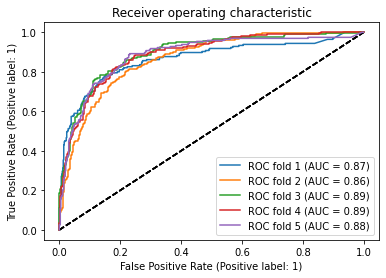

In [5]:
main()